# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [64]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.01

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias, b1]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [67]:
num_epochs = 200000
batch_size = 32

lossi = []
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

for i in range(num_epochs):
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{num_epochs:7d}: {loss:.4f}')
    # break

      0/ 200000: 2.2949
   1000/ 200000: 2.5337
   2000/ 200000: 1.9525
   3000/ 200000: 2.0272
   4000/ 200000: 2.5515
   5000/ 200000: 2.2980
   6000/ 200000: 2.4124
   7000/ 200000: 2.4361
   8000/ 200000: 2.0603
   9000/ 200000: 2.6384
  10000/ 200000: 2.4764
  11000/ 200000: 2.2785
  12000/ 200000: 2.4677
  13000/ 200000: 2.3137
  14000/ 200000: 1.9620
  15000/ 200000: 2.3053
  16000/ 200000: 2.1531
  17000/ 200000: 2.0439
  18000/ 200000: 2.6598
  19000/ 200000: 2.1299
  20000/ 200000: 2.0223
  21000/ 200000: 2.2607
  22000/ 200000: 2.3319
  23000/ 200000: 2.4754
  24000/ 200000: 2.0281
  25000/ 200000: 1.9434
  26000/ 200000: 2.1617
  27000/ 200000: 2.0457
  28000/ 200000: 2.5563
  29000/ 200000: 1.9873
  30000/ 200000: 2.3100
  31000/ 200000: 2.8306
  32000/ 200000: 2.2761
  33000/ 200000: 2.4504
  34000/ 200000: 2.1608
  35000/ 200000: 2.0217
  36000/ 200000: 2.0572
  37000/ 200000: 1.6604
  38000/ 200000: 1.5873
  39000/ 200000: 2.4656
  40000/ 200000: 2.4686
  41000/ 200000:

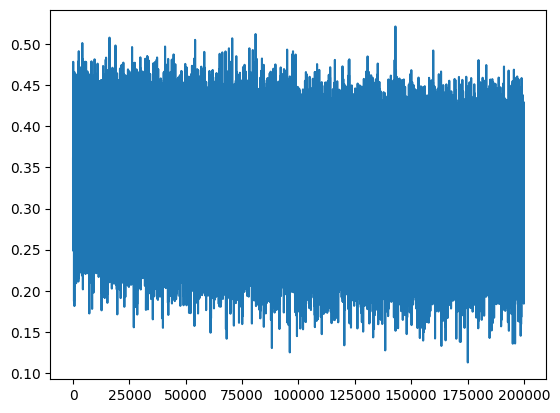

In [68]:
plt.plot(lossi)

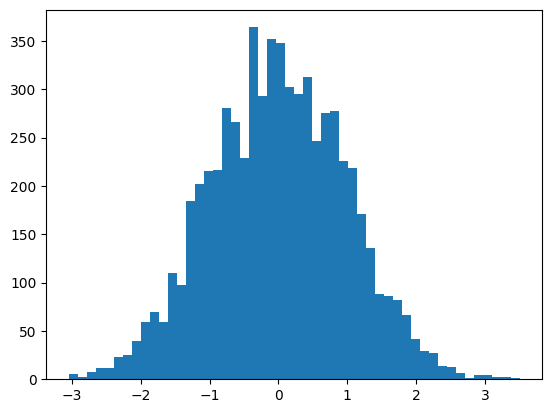

In [47]:
plt.hist(hpreact.view(-1).tolist(), 50);

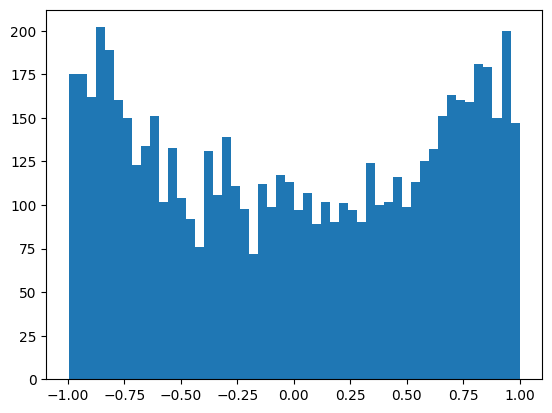

In [46]:
plt.hist(h.view(-1).tolist(), 50);

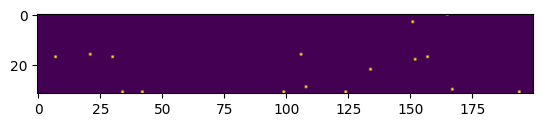

In [45]:
plt.imshow(h > 0.99)

In [69]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + 1e-5) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0664308071136475
val 2.1070902347564697


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [12]:
# SUMMARY + PYTORCHIFYING -----------

In [154]:
class Embedding:
    def __init__(self, vocab_size, emb_dim):
        self.weight = torch.randn(vocab_size, emb_dim)
    def __call__(self, x, concat=True):
        emb = x @ self.weight
        if concat:
            self.out = emb.view(x.shape[0], -1)
        else:
            self.out = emb
            
        return self.out
    
    def parameters(self):
        return [self.weight]

        
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + [] if self.bias is None else [self.bias]


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.mean_running = torch.ones(dim)
        self.var_running = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True

    def __call__(self, x):
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var= x.var(0, keepdim=True)
            with torch.no_grad():            
                self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * x_mean
                self.var_running = (1 - self.momentum) * self.var_running + self.momentum * x_var
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []


emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

layers = [
    Embedding(vocab_size, emb_dim),
    Linear(emb_dim * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3
parameters = [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

47024


In [155]:
num_epochs = 200000
batch_size = 32
lossi = []
ud = []

X_train = F.one_hot(Xtr, num_classes=vocab_size).float()

for i in range(num_epochs):
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    x, y = X_train[ix], Ytr[ix]

    # forward    
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)

    # backward:
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track
    if i % 10000 == 0:
        print(f'{i:7d}/{num_epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    break

      0/ 200000: 3.3214


layer  3: mean +0.00, std 0.63, saturated: 0.50%
layer  6: mean +0.00, std 0.64, saturated: 0.34%
layer  9: mean +0.00, std 0.63, saturated: 0.19%
layer 12: mean -0.00, std 0.63, saturated: 0.44%
layer 15: mean +0.00, std 0.64, saturated: 0.31%


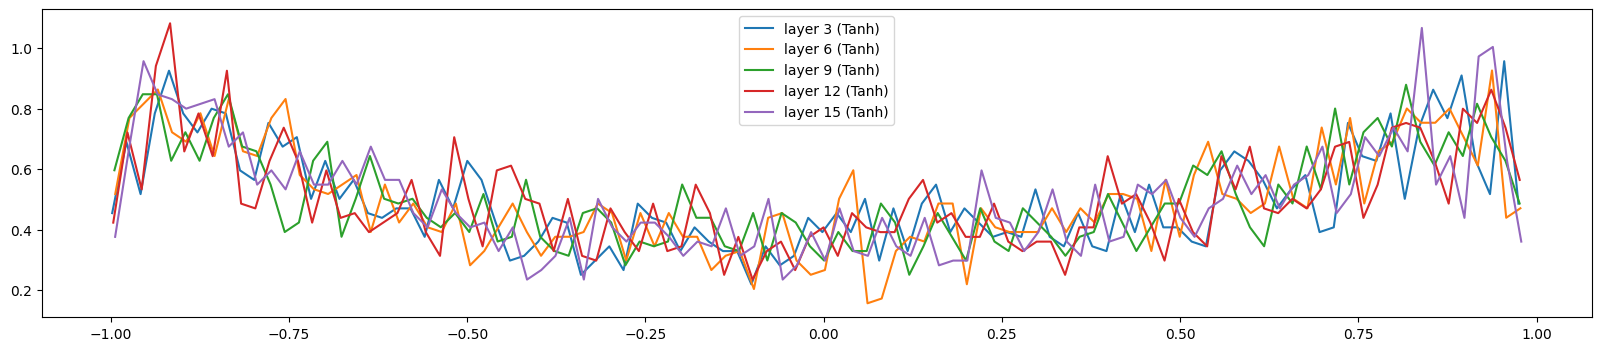

In [156]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        mean = t.mean()
        std = t.std()
        saturated = (t.abs() > 0.99).float().mean()*100
        print(f'layer {i:2d}: mean {mean:+.2f}, std {std:.2f}, saturated: {saturated:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.show()

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

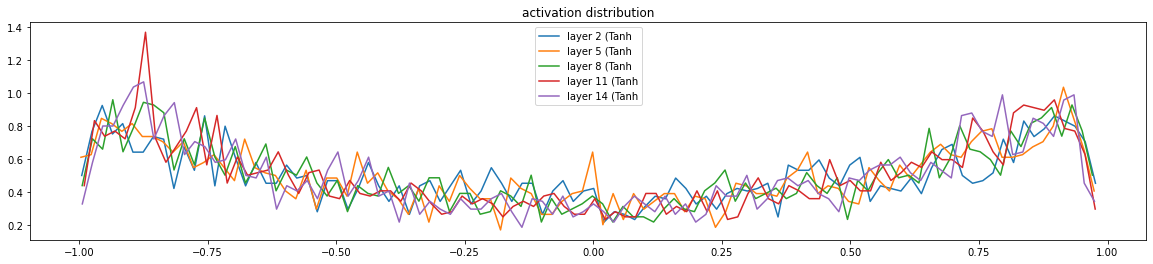

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

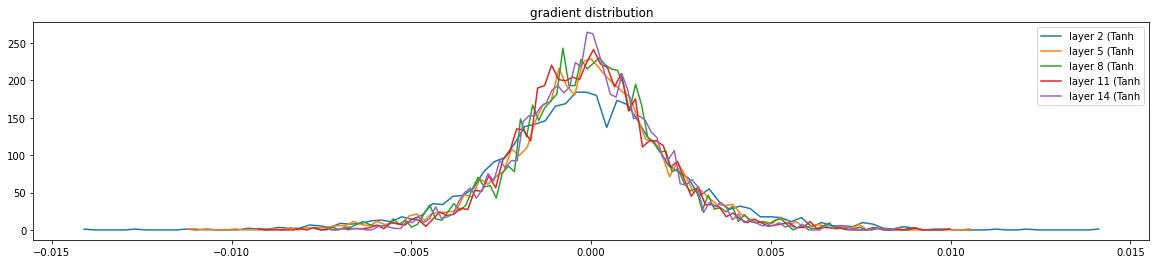

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241077e-03 | grad:data ratio 4.881091e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964619e-02
weight (100, 100) | mean -0.000086 | std 6.234305e-03 | grad:data ratio 6.073741e-02
weight (100, 100) | mean +0.000052 | std 5.742187e-03 | grad:data ratio 5.631483e-02
weight (100, 100) | mean +0.000032 | std 5.672205e-03 | grad:data ratio 5.570125e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


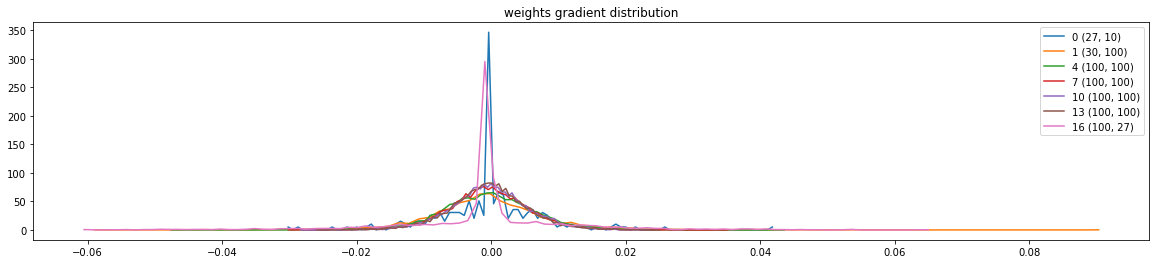

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

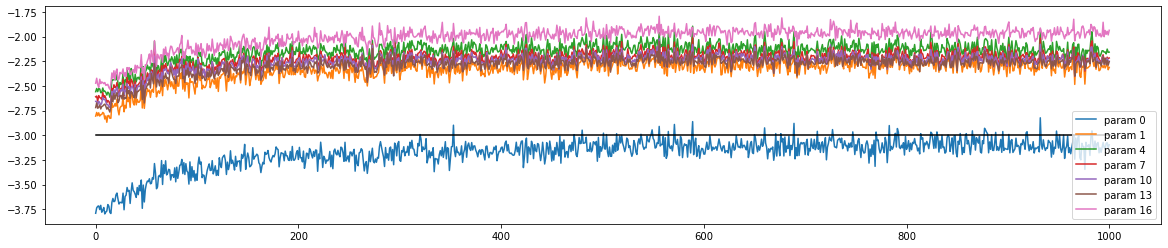

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.


In [21]:
# DONE; BONUS content below, not covered in video

In [22]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [23]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [24]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953052997589111
